In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Read cleanest data
data = pd.read_csv('creditcardmarketing_post_cleaning.csv', index_col='customer_number')

### 3. Modelling & Evaluation

#### 3.1. Define scaling, normalizing & encoding functions

##### 3.1.1. Data Scaling

In [4]:
def normalize_data(df):
    num = df.select_dtypes(np.number)
    transformer = MinMaxScaler().fit(num) 
    x_minmax = transformer.transform(num)
    num_norm = pd.DataFrame(x_minmax, columns=num.columns, index=num.index)
    return num_norm

##### 3.1.2. Box-Cox transformation

In [5]:
def boxcox_transform(data):
    numeric_cols = data.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        if len(data[column].unique()) < 100:
            continue
        else:
            data[column] = np.where(data[column] <= 0, np.NAN, data[column]) 
            data[column] = data[column].fillna(data[column].median())
            transformed_data, ci = stats.boxcox(data[column])
            data[column] = transformed_data
            _ci[column] = [ci] 
    return data

##### 3.1.3. Remove outliers

In [6]:
def remove_outliers(df, threshold=1.5):
    numerical = df.select_dtypes(np.number)
    columns = numerical.columns
    for column in columns:
        if len(df[column].unique()) < 100:
            continue
        else:
            upper = np.percentile(df[column], 75)
            lower = np.percentile(df[column], 25)
            iqr = upper - lower
            upper_limit = upper + threshold * iqr
            lower_limit = lower - threshold * iqr
            df = df[(df[column]>lower_limit) & (df[column]<upper_limit)]
    return df

##### 3.1.4. Encode categorical data (`get_dummies`)

In [7]:
def encode_cat(df, target):
    cat = df.select_dtypes(object)
    y = cat[target]
    cat.drop(target, axis=1, inplace=True)
    cat = pd.get_dummies(cat, columns=cat.columns, drop_first=True)
    cat = pd.concat([cat, y], axis=1)
    return cat

##### 3.1.5. Concatenate numerical and categorical data

In [8]:
def new_df(num, cat):
    new_df = pd.concat([num, cat], axis=1)
    return new_df

#### 3.2. Define evaluating functions

In [9]:
def classification_model(df, target, model, balance=None):
    y = df[target]
    X = df.drop(target, axis=1)
    if balance == None:
        X_train, X_test, y_train, y_test = train_test_split(X, y, \
        test_size=0.3, random_state=42)
    elif balance == "before":
        smote = SMOTE()
        X_sm, y_sm = smote.fit_resample(X, y)
        X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, \
        test_size=0.3, random_state=42)
    elif balance == "after":
        smote = SMOTE()
        X_train, X_test, y_train, y_test = train_test_split(X, y, \
        test_size=0.3, random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
    else:
        raise KeyError 
       
    model = model
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)        
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=["No", "Yes"], \
        yticklabels=["No", "Yes"])
    plt.show()
    rejected_offers = round(cm[0][0] * 100 / sum(cm[0]), 2)
    print("Rejected offers prediction accuracy:", rejected_offers, "%")
    accepted_offers = round(cm[1][1] * 100 / sum(cm[1]), 2)  
    print("Accepted offers prediction accuracy:", accepted_offers, "%")

In [10]:
regression_model = LogisticRegression(random_state=0, multi_class='ovr')

#### 3.3. Optimize model for the `offer_accepted`

##### 3.3.1. Use a mixture of transformations on the data excluding quarterly balances:

##### 3.3.1.1. All transformations

In [11]:
data_1 = data.copy()

# 0. Drop quarterly balances
to_drop = ['balance_Q1', 'balance_Q2', 'balance_Q3', 'balance_Q4']
data_1.drop(to_drop, axis=1, inplace=True)

# 1. Remove outliers
data_1 = remove_outliers(data_1)

# 2. Box-Cox transform
data_1 = boxcox_transform(data_1)

# 3. Scale numerical data
num_norm_1 = normalize_data(data_1)

# 4. Encode categorical data
cat_1 = encode_cat(data_1, 'offer_accepted')

# 5. Merge numerical & categorical data
new_df_1 = new_df(num_norm_1, cat_1)

/home/sabina/.local/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


a. Logistic Regression

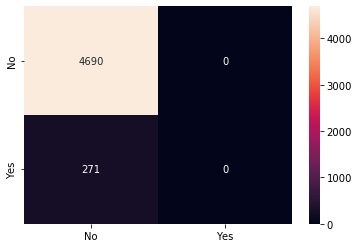

Rejected offers prediction accuracy: 100.0 %
Accepted offers prediction accuracy: 0.0 %


In [12]:
classification_model(new_df_1, 'offer_accepted', regression_model, balance=None)

We notice that the model incorrectly predicts when the offer will be accepted 100% of the time - therefore, we need to deal with the data imbalance before running the model.

b. Logistic Regression + pre-SMOTE

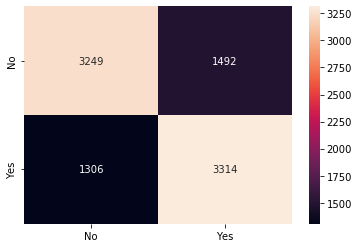

Rejected offers prediction accuracy: 68.53 %
Accepted offers prediction accuracy: 71.73 %


In [13]:
classification_model(new_df_1, 'offer_accepted', regression_model, balance="before")

By using SMOTE we improved the overall & individual accuracy of the predictions.

c. Logistic Regression + post-SMOTE

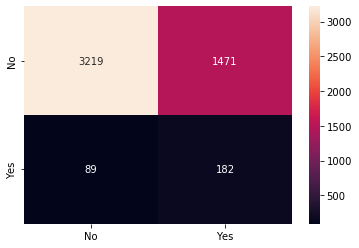

Rejected offers prediction accuracy: 68.64 %
Accepted offers prediction accuracy: 67.16 %


In [14]:
classification_model(new_df_1, 'offer_accepted', regression_model, balance="after")

The prediction accuracy is slightly lower in the post-SMOTE approach, but it is more balanced.

d. KNN model

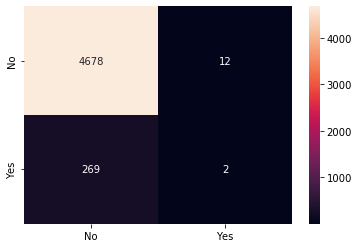

Rejected offers prediction accuracy: 99.74 %
Accepted offers prediction accuracy: 0.74 %


In [15]:
KNN_model = KNeighborsClassifier(n_neighbors=4)
classification_model(new_df_1, 'offer_accepted', KNN_model, balance=None)

We see that the score is only marginally higher with KNN (n=4) as opposed to the logistic regression model. We can also use different numbers of neighbors:

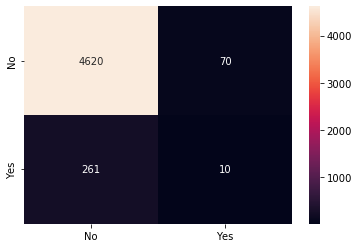

Rejected offers prediction accuracy: 98.51 %
Accepted offers prediction accuracy: 3.69 %


In [16]:
KNN_model = KNeighborsClassifier(n_neighbors=3)
classification_model(new_df_1, 'offer_accepted', KNN_model, balance=None)

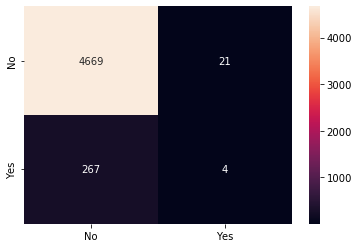

Rejected offers prediction accuracy: 99.55 %
Accepted offers prediction accuracy: 1.48 %


In [17]:
KNN_model = KNeighborsClassifier(n_neighbors=5)
classification_model(new_df_1, 'offer_accepted', KNN_model, balance=None)

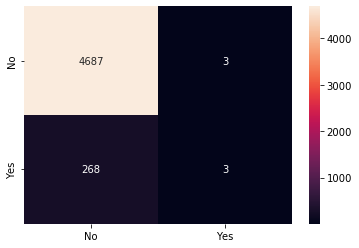

Rejected offers prediction accuracy: 99.94 %
Accepted offers prediction accuracy: 1.11 %


In [18]:
KNN_model = KNeighborsClassifier(n_neighbors=6)
classification_model(new_df_1, 'offer_accepted', KNN_model, balance=None)

We can see that the ideal number of neighbors to get a balanced accuracy would be n=3.

e. KNN model with pre-SMOTE

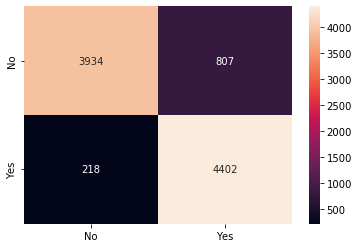

Rejected offers prediction accuracy: 82.98 %
Accepted offers prediction accuracy: 95.28 %


In [19]:
KNN_model = KNeighborsClassifier(n_neighbors=3)
classification_model(new_df_1, 'offer_accepted', KNN_model, balance="before")

f. KNN model with post-SMOTE

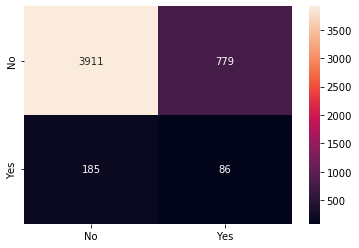

Rejected offers prediction accuracy: 83.39 %
Accepted offers prediction accuracy: 31.73 %


In [20]:
KNN_model = KNeighborsClassifier(n_neighbors=3)
classification_model(new_df_1, 'offer_accepted', KNN_model, balance="after")

The KNN classifier with SMOTE performs worse than the logistic regression model with SMOTE.

##### 3.3.2. Use a mixture of transformations on the data without excluding quarterly balances:

##### 3.3.2.1. All transformations

In [21]:
data_2 = data.copy()

# 1. Remove outliers
data_2 = remove_outliers(data_2)

# 2. Box-Cox transform
data_2 = boxcox_transform(data_2)

# 3. Scale numerical data
num_norm_2 = normalize_data(data_2)

# 4. Encode categorical data
cat_2 = encode_cat(data_2, 'offer_accepted')

# 5. Merge numerical & categorical data
new_df_2 = new_df(num_norm_2, cat_2)

/home/sabina/.local/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


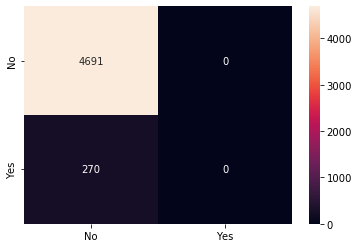

Rejected offers prediction accuracy: 100.0 %
Accepted offers prediction accuracy: 0.0 %


In [22]:
classification_model(new_df_2, 'offer_accepted', regression_model, balance=None)

There was no change in the logistic regression results due to removal of the quarterly balances.

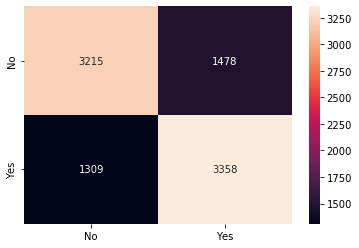

Rejected offers prediction accuracy: 68.51 %
Accepted offers prediction accuracy: 71.95 %


In [23]:
classification_model(new_df_2, 'offer_accepted', regression_model, balance="before")

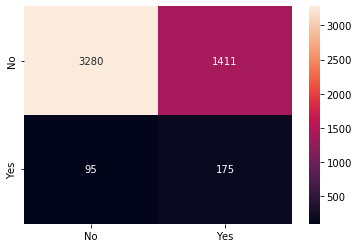

Rejected offers prediction accuracy: 69.92 %
Accepted offers prediction accuracy: 64.81 %


In [24]:
classification_model(new_df_2, 'offer_accepted', regression_model, balance="after")

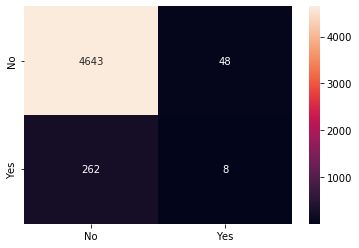

Rejected offers prediction accuracy: 98.98 %
Accepted offers prediction accuracy: 2.96 %


In [25]:
KNN_model = KNeighborsClassifier(n_neighbors=3)
classification_model(new_df_2, 'offer_accepted', KNN_model, balance=None)

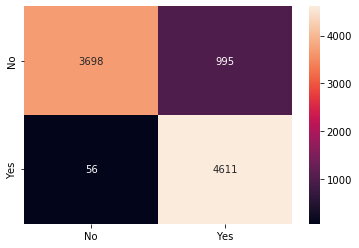

Rejected offers prediction accuracy: 78.8 %
Accepted offers prediction accuracy: 98.8 %


In [26]:
KNN_model = KNeighborsClassifier(n_neighbors=3)
classification_model(new_df_2, 'offer_accepted', KNN_model, balance="before")

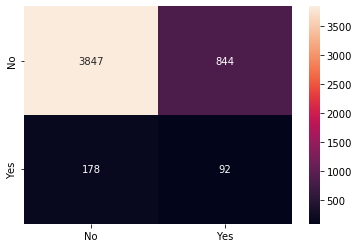

Rejected offers prediction accuracy: 82.01 %
Accepted offers prediction accuracy: 34.07 %


In [31]:
KNN_model = KNeighborsClassifier(n_neighbors=3)
classification_model(new_df_2, 'offer_accepted', KNN_model, balance="after")

We notice that both the models perform better when all of the balances are included.